<a href="https://colab.research.google.com/github/Vamsi995/DeepLense-ML4SCI-EvalTest/blob/main/DeepLense_Test_I_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
import pandas as pd
import time
import torch.nn.functional as F
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

seed = 43
torch.manual_seed(seed)

# Utilities


In [2]:
class SubstructureData:
  """
    Substructure Data Class is a wrapper class that helps in handling data manipulation.
  """
  def __init__(self, paths):
    self.paths = paths
    self.train_df = None
    self.val_df = None
    self.test_df = None
    self.initialize_data_dict()

  def initialize_data_dict(self):
    """
      Initialize data dict
    """

    self.data = {}

    for stage in self.paths.keys():
      self.data[stage] = {}

    for stage, value_dict in self.paths.items():
      for substrc_key, path in value_dict.items():
        self.data[stage][substrc_key] = []

  def load_data(self):
    """
      Load Data from disk
    """
    for stage, value_dict in self.paths.items():
      for substrc_key, path in value_dict.items():
        for substrc in tqdm(os.listdir(path), desc="Reading {} {} Images from {}".format(stage, substrc_key, path)):
          substrc_image = np.load(path + substrc, allow_pickle=True)
          self.data[stage][substrc_key].append(np.float32(substrc_image))

        print("No. of {} {} images loaded: {}".format(stage, substrc_key, len(self.data[stage][substrc_key])))

  def construct_dataframes(self):
    """
      Construct dataframes from the loaded data
    """
    train_nosub_dict = {"Images": self.data["train"]["nosub"],
              "Labels": [0]*len(self.data["train"]["nosub"]) 
              }
    train_vortex_dict = {"Images": self.data["train"]["vortex"],
                  "Labels": [1]*len(self.data["train"]["vortex"]) 
                  }
    train_sphere_dict = {"Images": self.data["train"]["sphere"],
                  "Labels": [2]*len(self.data["train"]["sphere"]) 
                  }

    val_nosub_dict = {"Images": self.data["val"]["nosub"],
                  "Labels": [0]*len(self.data["val"]["nosub"]) 
                  }
    val_vortex_dict = {"Images": self.data["val"]["vortex"],
                  "Labels": [1]*len(self.data["val"]["vortex"]) 
                  }
    val_sphere_dict = {"Images": self.data["val"]["sphere"],
                  "Labels": [2]*len(self.data["val"]["sphere"]) 
                  }


    train_nosub_df = pd.DataFrame(train_nosub_dict)
    train_vortex_df = pd.DataFrame(train_vortex_dict)
    train_sphere_df = pd.DataFrame(train_sphere_dict)

    val_nosub_df = pd.DataFrame(val_nosub_dict)
    val_vortex_df = pd.DataFrame(val_vortex_dict)
    val_sphere_df = pd.DataFrame(val_sphere_dict)

    self.train_df = pd.concat([train_nosub_df, train_vortex_df, train_sphere_df], axis=0)
    self.val_df = pd.concat([val_nosub_df, val_vortex_df, val_sphere_df], axis=0)

    print("Total no. of training samples: {}".format(len(self.train_df)))
    print("Total no. of validation samples: {}".format(len(self.val_df)))
  
  def calc_mean_std(self, dataset):
    """
      Calculate mean and std for the entire dataset
    """
    psum = 0
    pstd = 0
    for image in dataset:
      image = self.min_max_filter(image)
      psum += image.sum() 
      pstd += (image**2).sum()
    
    image = dataset.sample(n=1)["Images"].values[0]
    height = image.shape[1]
    width = image.shape[2]
    total_pixels = (len(dataset)*height*width)
    mean = psum/total_pixels
    std = np.sqrt((pstd/total_pixels) - (mean**2))

    print("Mean: {}, Std: {}".format(mean, std))
    return mean, std

  def train_test_val_split(self):
    """
      Train test split for the data
    """

    self.train_df, self.test_df = train_test_split(self.train_df, test_size=0.1, random_state=43, stratify=self.train_df["Labels"])
    print("No. of training data samples: {}".format(len(self.train_df)))
    print("No. of testing data samples: {}".format(len(self.test_df)))
    print("No. of validation data samples: {}".format(len(self.val_df)))


# Import Data

- Importing data by copying the dataset to google drive and mounting google drive to the colab notebook. 

- Please try to access this notebook via colab.


In [3]:
# Connecting to my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- The path (/drive/MyDrive/ML4SCI/dataset.zip) below to the dataset is the path in my google drive, please change it accordingly and point it to the dataset path in your drive.

In [4]:
# Create images/ directory
!mkdir images

# Unzipping zip file
!unzip "/content/drive/MyDrive/ML4SCI/dataset.zip" -d "images/"

Streaming output truncated to the last 5000 lines.
  inflating: images/dataset/val/no/531.npy  
  inflating: images/dataset/val/no/257.npy  
  inflating: images/dataset/val/no/243.npy  
  inflating: images/dataset/val/no/525.npy  
  inflating: images/dataset/val/no/1099.npy  
  inflating: images/dataset/val/no/1927.npy  
  inflating: images/dataset/val/no/1933.npy  
  inflating: images/dataset/val/no/519.npy  
  inflating: images/dataset/val/no/1066.npy  
  inflating: images/dataset/val/no/1700.npy  
  inflating: images/dataset/val/no/294.npy  
  inflating: images/dataset/val/no/2209.npy  
  inflating: images/dataset/val/no/280.npy  
  inflating: images/dataset/val/no/1714.npy  
  inflating: images/dataset/val/no/1072.npy  
  inflating: images/dataset/val/no/2235.npy  
  inflating: images/dataset/val/no/1728.npy  
  inflating: images/dataset/val/no/2221.npy  
  inflating: images/dataset/val/no/733.npy  
  inflating: images/dataset/val/no/727.npy  
  inflating: images/dataset/val/no/150

In [5]:
# Path to data on disk
paths = {
  "train": {
    "nosub": "/content/images/dataset/train/no/",
    "vortex": "/content/images/dataset/train/vort/",
    "sphere": "/content/images/dataset/train/sphere/",
  },

  "val": {  
    "nosub": "/content/images/dataset/val/no/",
    "vortex":  "/content/images/dataset/val/vort/",
    "sphere": "/content/images/dataset/val/sphere/"
  }
}


In [6]:
# Custom data wrapper 
substrc_data = SubstructureData(paths)

In [7]:
# Load data from disk
substrc_data.load_data()

Reading train nosub Images from /content/images/dataset/train/no/:   0%|          | 0/10000 [00:00<?, ?it/s]

No. of train nosub images loaded: 10000


Reading train vortex Images from /content/images/dataset/train/vort/:   0%|          | 0/10000 [00:00<?, ?it/s…

No. of train vortex images loaded: 10000


Reading train sphere Images from /content/images/dataset/train/sphere/:   0%|          | 0/10000 [00:00<?, ?it…

No. of train sphere images loaded: 10000


Reading val nosub Images from /content/images/dataset/val/no/:   0%|          | 0/2500 [00:00<?, ?it/s]

No. of val nosub images loaded: 2500


Reading val vortex Images from /content/images/dataset/val/vort/:   0%|          | 0/2500 [00:00<?, ?it/s]

No. of val vortex images loaded: 2500


Reading val sphere Images from /content/images/dataset/val/sphere/:   0%|          | 0/2500 [00:00<?, ?it/s]

No. of val sphere images loaded: 2500


In [8]:
# Construct dataframes
substrc_data.construct_dataframes()

Total no. of training samples: 30000
Total no. of validation samples: 7500


Classes - Labels

- No Substructure - 0
- Vortex Substructure - 1
- Sphere Substructure - 2

# Data Analysis


## Image Analysis


In [9]:
# Image properties
image = substrc_data.train_df.sample(n=1)["Images"].values[0]
print("Image Type: {}".format(type(image)))
print("Image Shape: {}".format(image.shape))
print("Image Data Type: {}".format(image.dtype))
print("Image Dimensions: {}".format(image.ndim))

Image Type: <class 'numpy.ndarray'>
Image Shape: (1, 150, 150)
Image Data Type: float32
Image Dimensions: 3


[Text(0.5, 1.0, 'Pixel Distribution')]

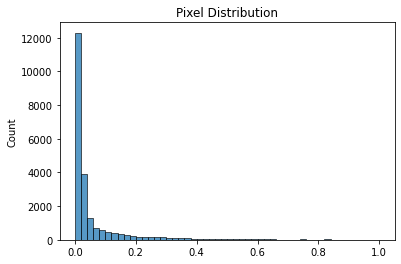

In [10]:
# Pixel distribution
sns.histplot(image.ravel(), bins=50).set(title="Pixel Distribution")

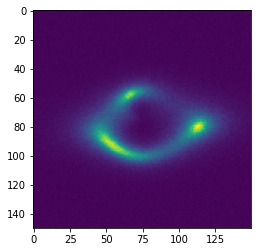

In [11]:
# Image visualization
plt.imshow(image[0])

### Image Normalization

We can see that the pixel distribution is heavily skewed, this might affect the gradients during backpropagation. The neuron will become saturated if you multiply your weights by large pixel values. But eventually, in order to offset the impact of the large input, your weights will be updated to really small values. Sadly, this will not occur because the gradients for saturated activations will be too small to allow for any appreciable update. Your weights will eventually become stuck. 

Standardization

These initial inputs will be multiplied (weighted) and added to (biassed) in order to produce activations, which we will then backpropogate with the gradients to train the model. We want each feature in this process to have a comparable range so that our gradients don't get out of hand (and that we only need one global learning rate multiplier). Another way to think about it is that deep learning networks typically share a lot of parameters. If your inputs weren't scaled to produce similarly-ranged feature values (i.e., across the entire dataset by removing the mean), sharing wouldn't be very straightforward because w is too big for some regions of the image and too small for others.

             
>>> $ Z = \Large\frac{x - μ}{σ}$, where $μ$ is the mean and $σ$ is the standard deviation.

In [12]:
# Constructing entire dataset
total_df = pd.concat([substrc_data.train_df, substrc_data.val_df], axis = 0)

In [13]:
# Calculating mean/std for the entire dataset
def calc_mean_std(dataset):
  psum = 0
  pstd = 0
  for i in range(len(dataset)):
    image = dataset.iloc[i, 0]
    psum += image.sum() 
    pstd += (image**2).sum()
  
  image = dataset.sample(n=1)["Images"].values[0]
  height = image.shape[1]
  width = image.shape[2]
  total_pixels = (len(dataset)*height*width)
  mean = psum/total_pixels
  std = np.sqrt((pstd/total_pixels) - (mean**2))

  print("Mean: {}, Std: {}".format(mean, std))
  return mean, std

In [14]:
# Mean/Std
mean, std = calc_mean_std(total_df)

Mean: 0.061701331169849535, Std: 0.11730575144553053


In [15]:
# Standardized Image
image = substrc_data.train_df.sample(n=1)["Images"].values[0]
standardized_image = (image - mean)/std

[Text(0.5, 1.0, 'Standardized Pixel Distribution')]

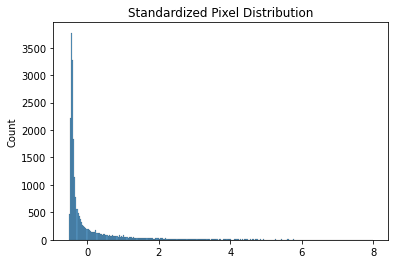

In [16]:
# Pixel Distribution
sns.histplot(standardized_image.ravel()).set(title="Standardized Pixel Distribution")

## Label Analysis

In [17]:
# Label Properties
label = substrc_data.train_df.sample(n=1)["Labels"].values[0]
print("Image Type: {}".format(type(label)))
print("Label Shape: {}".format(label.shape))
print("Label Data Type: {}".format(label.dtype))

Image Type: <class 'numpy.int64'>
Label Shape: ()
Label Data Type: int64


[Text(0.5, 1.0, 'Label Distribution')]

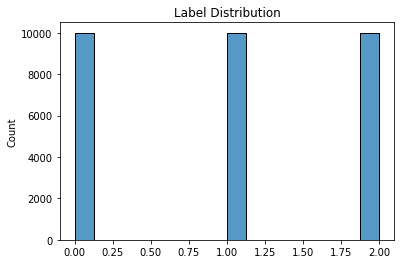

In [18]:
# Label Distribution
sns.histplot(substrc_data.train_df["Labels"].tolist()).set(title="Label Distribution")

# Data Pipeline
- Train/Test/Val Split
- Data Transformations/Augmentations
- Custom Pytorch Dataset
- Pytorch DataLoader

## Train/Test/Val Split


In [19]:
# Train - Test Split -> 90:10
substrc_data.train_test_val_split()

No. of training data samples: 27000
No. of testing data samples: 3000
No. of validation data samples: 7500


[Text(0.5, 1.0, 'Train Label Distribution After Split')]

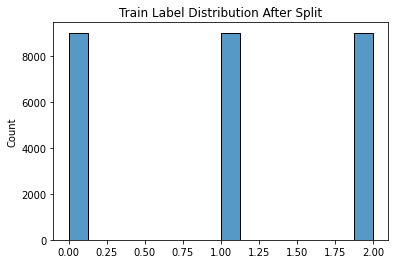

In [20]:
sns.histplot(substrc_data.train_df["Labels"].tolist()).set(title="Train Label Distribution After Split")

[Text(0.5, 1.0, 'Test Label Distribution')]

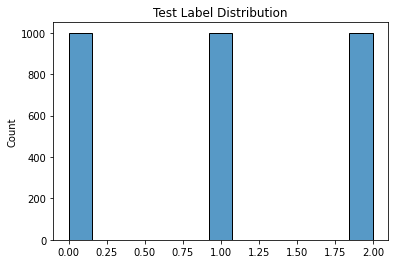

In [21]:
sns.histplot(substrc_data.test_df["Labels"].tolist()).set(title="Test Label Distribution")

## Data Transformations

Performing Data Augmentations as per [[2]](https://arxiv.org/pdf/1909.07346.pdf)

In [22]:
# Data Transformations
data_transformations = {
  "train" : transforms.Compose([
      transforms.ToTensor(),
      # Data Standardization
      transforms.Normalize([0.06170],[0.11730]),
      # Data Augmentation
      transforms.RandomRotation(degrees=(0,90))
  ]),

  "test": transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.06170],[0.11730])
  ]),

  "val": transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.06170],[0.11730])
  ])
}

## Custom Dataset

In [23]:
class SubstructureDataset(Dataset):
  """
    Custom Pytorch Dataset 
  """
  def __init__(self, dataframe, transforms):
    self.dataframe = dataframe
    self.transforms = transforms

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    image, label = self.dataframe.iloc[idx]

    if self.transforms is not None:
      image = self.transforms(image[0])
    else:
      image = torch.from_numpy(image[0])

    return image, torch.tensor(label)
    


In [24]:
# Dataset Dict
dataset_dict = {
    "train": SubstructureDataset(substrc_data.train_df, data_transformations["train"]),
    "val": SubstructureDataset(substrc_data.val_df, data_transformations["val"]),
    "test": SubstructureDataset(substrc_data.test_df, data_transformations["test"])
}

## DataLoaders

Upon iterating over several batch sizes, the batch size of 64 seems to be giving an optimal trade off between training time and classification metrics.

In [25]:
# Initialize dataloaders
train_dataloader = DataLoader(dataset_dict["train"], batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(dataset_dict["val"], batch_size=64, num_workers=2, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(dataset_dict["test"], batch_size=64, num_workers=2, shuffle=False)

# Model
- Model Definition
- Loss Function
- Optimizer
- Training

## Model Definition

[Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) is used as the backbone model. Resnet and resnet like architectures have shown significant performance when it comes to image classification, and hence I am using this as a feature extractor into the dense layer. I chose resnet18 over other deeper networks because of lesser training time and limited GPU resource. The fully connected layer of resnet is modified by adding a dense layer for classification with 3 neuron output, one for each class. The input layer of the resnet is modified to take in single channel images.

>**NOTE**: Softmax layer is not added in the definition of the model since we are using [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). According to the pytorch docs, this loss function applies the log softmax layer intrinsicly and computes the NLL loss.

One clever optimization of the model would be to freeze the initial base layers upto a depth of 5 or less, and then fine tune the model to this task. This way we can reduce the training time and also leverage the resnets early layers that capture basic information like curves/edges in an image.

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# PyTorch models inherit from torch.nn.Module
class SubstructureClassifier(nn.Module):
    def __init__(self):
        super(SubstructureClassifier, self).__init__()
        self.resnet = torchvision.models.resnet18(weights=None)
        # Modifying first layer to accpet single channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        layers = []
        layers += [nn.Linear(512, 256, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(256, 16, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(16,3)]
        self.resnet.fc = nn.Sequential(*layers)


    def forward(self, x):
        return self.resnet(x)

model = SubstructureClassifier()
model.to(device=device)

SubstructureClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

## Loss Function

In [33]:
loss_fn = nn.CrossEntropyLoss()

## Optimizer

I chose the Adam optimizer according to the papers [[2,3]]() where the resnet acheived a remarkable training accuracy of ~97%. I initialized them according to the values in the paper. I also used a one cycle lr scheduler [[4]](https://arxiv.org/abs/1803.09820v2) in place of a cyclic scheduler as mentioned in the paper [[3]]() as it performed relatively better.

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr = 1e-2,
                       steps_per_epoch = len(train_dataloader), 
                       epochs = 100,
                       anneal_strategy = 'cos')

## Training

Strategy


- Early Stopping: The training loop is set in a way that if the val loss does not improve for the next 15 epochs, then we stop and save the best model with maximum val acc according to the paper [[3]](https://arxiv.org/pdf/2112.12121.pdf).

- Model Checkpoints: The model checkpointing starts after 25 epochs where the model is saved if the validation acc increases above the max validation acc.


In [35]:
class TrainWrapper:
  """
    Train Wrapper for training
  """
  def __init__(self, epochs):
    self.epochs = epochs
    self.threshold_epoch = 15
    self.initialize_tracking()

  
  def initialize_tracking(self):
    self.accuracy_per_epoch = {}
    self.loss_per_epoch = {}

    self.accuracy_per_epoch["train"] = []
    self.accuracy_per_epoch["val"] = []

    self.loss_per_epoch["train"] = []
    self.loss_per_epoch["val"] = []


  def get_accuracy(self, outputs, labels):

    return (outputs.argmax(dim=1) == labels).float().sum().item()
    

  def run_epoch(self, data_loader, train):
    start_time = time.time()

    running_loss = 0.
    total_samples = 0
    correct_pred = 0

    if train:
      model.train()
    else:
      model.eval()

    self.min_val_loss = float("inf")
    self.stop_counter = 0


    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device=device), labels.to(device=device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        if train:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


        running_loss += loss.item()
        total_samples += labels.size(0)
        correct_pred += self.get_accuracy(outputs, labels)

    return running_loss/len(data_loader), correct_pred/total_samples

  def train(self):

    self.max_val_acc = 0
    self.stop_counter = 0

    for ep in tqdm(range(self.epochs), desc='Training loop'):
      start_time = time.time()

      # Train one epoch
      # Validate one epoch
      # LR Scheduler Step
      train_loss, train_acc = self.run_epoch(train_dataloader, train=True)
      val_loss, val_acc = self.run_epoch(val_dataloader, train=False)
      scheduler.step()

      self.loss_per_epoch["train"].append(train_loss)
      self.loss_per_epoch["val"].append(val_loss)

      self.accuracy_per_epoch["train"].append(train_acc)
      self.accuracy_per_epoch["val"].append(val_acc)

      self.checkpoint(ep+1, val_acc)

      print("Epoch: {} - Train loss: {}, Val Loss: {}, Train Acc: {}, Val Acc: {}, Time Elapsed: {}".format(ep+1, train_loss, val_loss, train_acc, val_acc, time.time() - start_time))

      if self.stop_early():
        print("Stopping Training since Val Acc has not improved for {} epochs".format(self.threshold_epoch))
        break

  def test(self):
    model.eval()
    test_loss, test_acc = self.run_epoch(test_dataloader, train=False)
    print("Test Loss: {}, Test Acc: {}".format(test_loss, test_acc))

  def checkpoint(self, epoch_num, val_acc):
    if epoch_num >= 25:
      if self.max_val_acc < val_acc:
        self.save()
        print("--- Saving model ---")
        self.max_val_acc = val_acc
        self.stop_counter = 0
      else:
        self.stop_counter += 1


  def stop_early(self):
    return self.stop_counter == self.threshold_epoch

  def get_test_preds_labels(self):

    y_true = None
    y_test = None
    with torch.no_grad():
      for i, data in enumerate(test_dataloader):
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device=device)
        logits = model(inputs)
        y_prob = F.softmax(logits, dim=1)
        y = F.one_hot(labels, num_classes=3)

        if y_true is None:
          y_true = y
        else:
          y_true = torch.cat([y_true, y], 0)
        
        if y_test is None:
          y_test = y_prob
        else:
          y_test = torch.cat([y_test, y_prob], 0)
        
        del inputs
    return y_true.numpy(), y_test.cpu().detach().numpy()
  
  def save(self):
    classification_model_name = "SubstructureClassification"
    self.model_save_path = F"/content/drive/MyDrive/2023 ML/Model Weights/{classification_model_name}"
    torch.save(model.state_dict(), self.model_save_path)

  def load(self):
    classification_model_name = "SubstructureClassification"
    self.model_save_path = F"/content/drive/MyDrive/2023 ML/Model Weights/{classification_model_name}"
    if torch.cuda.is_available():
      model.load_state_dict(torch.load(self.model_save_path))
    else:
      model.load_state_dict(torch.load(self.model_save_path, map_location=torch.device('cpu')))

  def plot_roc_curves(self):
    y_true, y_pred = trainer.get_test_preds_labels()
    fig, ax = plt.subplots(figsize=(6, 6))
    class_dict = {
        0: "NoSub",
        1: "Vortex",
        2: "Sphere"
    }
    n_classes = 3

    self.plot_macro_roc(y_true, y_pred, n_classes)
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true[:, class_id],
            y_pred[:, class_id],
            name=f"ROC {class_dict[class_id]}",
            color=color,
            ax=ax,
        )
    
    plt.plot([0, 1], [0, 1], "k--", label="Baseline (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves")
    plt.legend()
    plt.show()
  
  def plot_macro_roc(self, y_true, y_pred, n_classes):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.plot(
      fpr["macro"],
      tpr["macro"],
      label=f"Macro-Average ROC (AUC = {roc_auc['macro']:.2f})",
      color="navy",
      linestyle=":",
      linewidth=4,
    )

  
  def classification_report(self):
    y_true, y_pred = self.get_test_preds_labels()
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_true, y_pred))

  def plot_confusion_matrix(self):
    plt.figure(figsize=(10,6))
    y_true, y_pred = self.get_test_preds_labels()
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    fx=sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".2f",cmap="GnBu")
    fx.set_title('Confusion Matrix \n');
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels(['NoSub','Vortex','Sphere'])
    fx.yaxis.set_ticklabels(['NoSub','Vortex','Sphere'])
    plt.show()

  def plot_metrics(self):
    imagefig, axes = plt.subplots(1,2, figsize=(30,10))
    axes[0].set_title("Loss")
    axes[0].plot(np.arange(len(self.loss_per_epoch["train"])+1)[1:], self.loss_per_epoch["train"], label="train")
    axes[0].plot(np.arange(len(self.loss_per_epoch["val"])+1)[1:], self.loss_per_epoch["val"], label="val")
    axes[0].legend()

    axes[1].set_title("Accuracy")
    axes[1].plot(np.arange(len(self.accuracy_per_epoch["train"])+1)[1:], self.accuracy_per_epoch["train"], label="train")
    axes[1].plot(np.arange(len(self.accuracy_per_epoch["train"])+1)[1:], self.accuracy_per_epoch["val"], label="val")
    axes[1].legend()

In [36]:
# Initialize Train Wrapper
trainer = TrainWrapper(100)

In [37]:
# Start Training
trainer.train()

Training loop:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 - Train loss: 1.1002105256957466, Val Loss: 1.0985089055562423, Train Acc: 0.3380740740740741, Val Acc: 0.3348, Time Elapsed: 53.40833020210266
Epoch: 2 - Train loss: 1.09909858438076, Val Loss: 1.098329708737842, Train Acc: 0.34185185185185185, Val Acc: 0.34826666666666667, Time Elapsed: 53.804832220077515
Epoch: 3 - Train loss: 1.098930211711269, Val Loss: 1.0982883774628074, Train Acc: 0.3385185185185185, Val Acc: 0.334, Time Elapsed: 52.63376569747925
Epoch: 4 - Train loss: 1.0983028423164694, Val Loss: 1.1221040239778615, Train Acc: 0.34285185185185185, Val Acc: 0.3337333333333333, Time Elapsed: 54.00041747093201
Epoch: 5 - Train loss: 1.096642150133142, Val Loss: 1.0965702250852423, Train Acc: 0.3546666666666667, Val Acc: 0.3505333333333333, Time Elapsed: 53.726314544677734
Epoch: 6 - Train loss: 1.0964461759933364, Val Loss: 1.1054431710202814, Train Acc: 0.350962962962963, Val Acc: 0.3333333333333333, Time Elapsed: 54.237448930740356
Epoch: 7 - Train loss: 1.0920139876

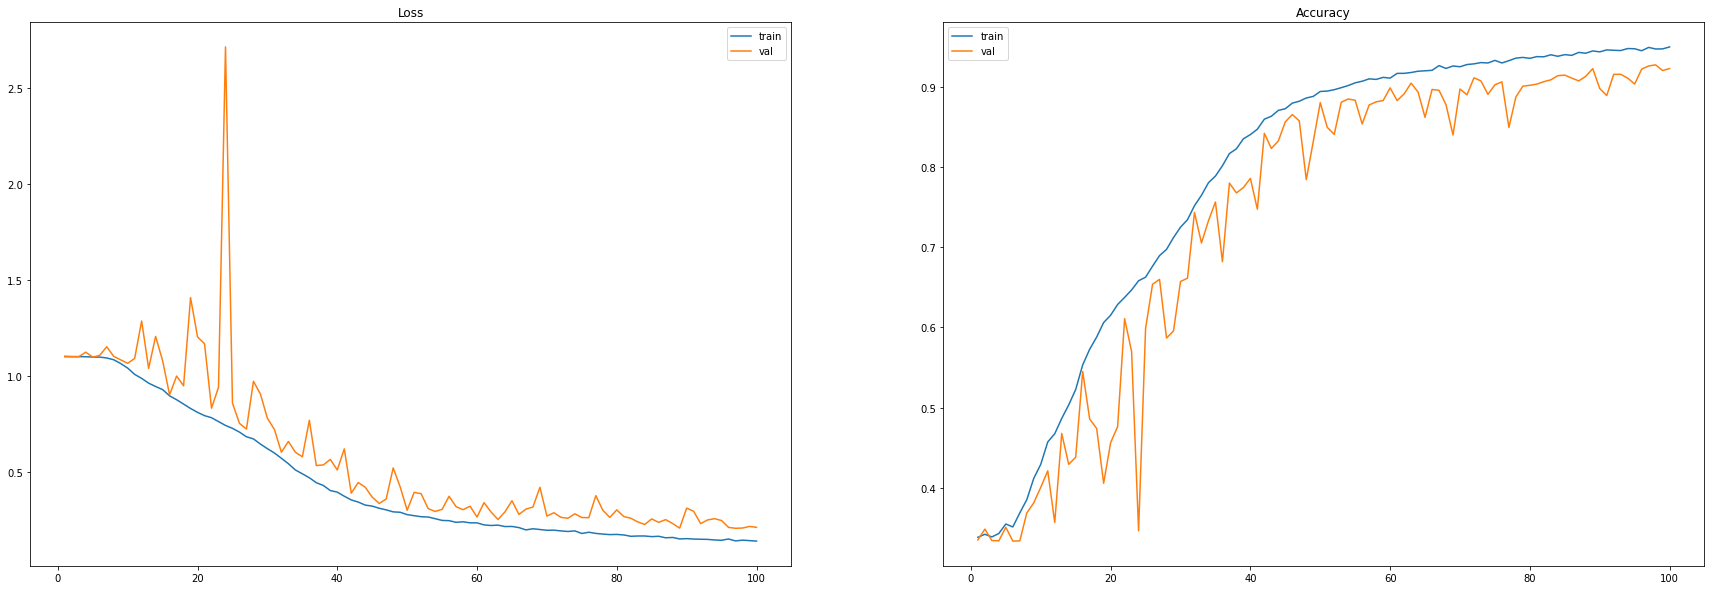

In [40]:
# Plot loss and accuracy curves
trainer.plot_metrics()

In [41]:
# Inference on the test data
trainer.test()

Test Loss: 0.21003351217888772, Test Acc: 0.9206666666666666


# ROC/AUC

Here is a link to my [model](https://drive.google.com/file/d/1cHz89YnG22v7lUcOdKtBhbPSbFRhGx14/view?usp=share_link), you can just call the load function here as the path to my model in drive is defined inside the load method.

In [42]:
# Loading saved model
trainer.load()

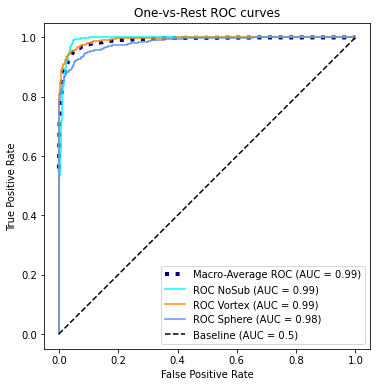

In [43]:
# Plotting One vs Rest ROC curves
trainer.plot_roc_curves()

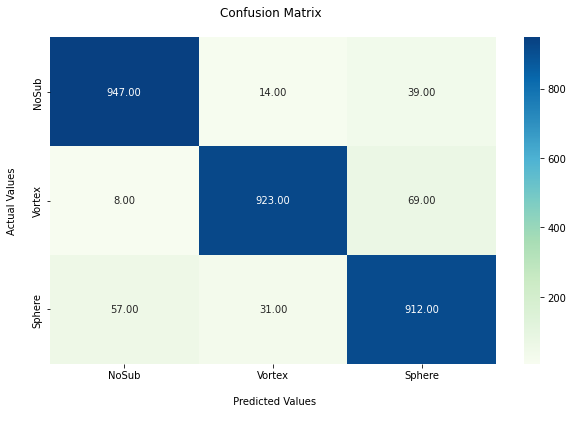

In [44]:
# Confusion Matrix
trainer.plot_confusion_matrix()

In [45]:
# Classification Report
trainer.classification_report()

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1000
           1       0.95      0.92      0.94      1000
           2       0.89      0.91      0.90      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



# Conclusion

- We can see that resnet has performed relatively well, and has acheived a decent macro average AUC score of 0.99. 

- One problem we can see is the spikes in validation loss and validation accuracy, which can be mitigated if we apply proper regularization which includes, 
 - Ridge/Lasso Regression (L2/L1 Regularization)

 - Adding drop out layers in the model

 - Better data augmentation

- Things that I missed/couldn't include because of time constraint:

 - Initializing weights using Kaiming Initialization for better convergence. [Weight Initializaiton](https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html#Solution:-Let's-Compare-Differrent-Initialization-Strategies)

 - Cross validation for getting the most optimal data split into the network. [Cross Validation](https://www.cs.cmu.edu/~schneide/tut5/node42.html)
 - Adding Proxy Normalizatin Layers instead of Batch Normalization [Proxy-Normalizing Activations to Match Batch Normalization while Removing Batch Dependence
](https://arxiv.org/pdf/2106.03743.pdf)
 - Adapting to [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/)

# References

1. [Decoding Dark Matter Substructure without Supervision](https://arxiv.org/pdf/2008.12731.pdf)

2. [Deep Learning the Morphology of Dark Matter Substructure](https://arxiv.org/pdf/1909.07346.pdf)

3. [Domain Adaptation for Simulation-Based Dark Matter Searches
Using Strong Gravitational Lensing](https://arxiv.org/pdf/2112.12121.pdf)

4. [A DISCIPLINED APPROACH TO NEURAL NETWORK
HYPER-PARAMETERS: PART 1 – LEARNING RATE,
BATCH SIZE, MOMENTUM, AND WEIGHT DECAY](https://arxiv.org/abs/1803.09820v2)

5. [A Visual Guide to Learning Rate Schedulers in PyTorch](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863)

6. [Deep transfer learning for image classification: a survey
](https://arxiv.org/pdf/2205.09904.pdf)

7. [FineTuning TorchVision Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

8. [The Effect of the Normalization Method Used in Different Sample Sizes on
the Success of Artificial Neural Network Model](https://files.eric.ed.gov/fulltext/EJ1246486.pdf)

9. [Classification: ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20(receiver%20operating,False%20Positive%20Rate)